In [70]:
# import packages used in various tutorials
from urllib import urlencode
from urllib import urlretrieve

import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
import numpy as np
import emcee
import scipy.optimize as op
import corner
from IPython.display import Image

from astropy.visualization import astropy_mpl_style
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
astropy.utils.data.Conf.remote_timeout = 60.0    # set database search timeout to 60s
%matplotlib inline

## Exercise 1 from Astropy Tutorial ##

In [70]:
# Get SkyCoord object for M17
M17 = SkyCoord.from_name('M17')

In [71]:
# Print sexigesimal coordinates of M17 in one line
print albireo.to_string(style='hmsdms')

19h30m43.2805s +27d57m34.8483s


In [72]:
# Get image from DSS using STScI archive
cutoutbaseurl = 'http://archive.stsci.edu/cgi-bin/dss_search'
query_string = urlencode(dict(f='GIF',
                              r=M17.ra.deg,
                              d=M17.dec.deg))
url = cutoutbaseurl + '?' + query_string

# Save image to disk
urlretrieve(url, 'M17_cutout.jpg')

# Display image without saving to disk
Image(url=url)

## Problem 2: Finding Stars Near a Designated Location ##

In [193]:
# Choose location to search near
loc = SkyCoord("14:29:42.94853 +62:40:46.1631", unit=(u.hourangle, u.deg))
# Create Vizier object to search for stars
v = Vizier(keywords=['stars'])
# Search for stars within 1 degree of above location
result = v.query_region(loc, radius=1*u.deg)

In [229]:
# Find indices where tables stored in result have only 1 row
indices = []
for i in range(len(result)):
    if len(result[i]) == 1:
        indices.append(i)
# Choose first three as stars of interest
star1 = result[indices[0]]
star2 = result[indices[1]]
star3 = result[indices[2]]

In [226]:
# Look at tables for stars
star1.pprint()
print '\n'
star2.pprint()
print '\n'
star3.pprint()
# Note: to figure out what columns mean for star x, use starx.info()
# To extract values, use starx['colname'][0]
# For example, star3['RA_ICRS_'][0] extracts the right ascension of star 3 in the ICRS frame

FK4    GC  mpv  SpType ...   DEB1950       pmDE     _RA.icrs     _DE.icrs  
           mag         ...   "d:m:s"    arcs / ha   "h:m:s"      "d:m:s"   
---- ----- ---- ------ ... ------------ --------- ------------ ------------
3150 19595  6.0     F5 ... +63 24 22.74      0.82 14 30 45.937 +63 11 08.88


FK4    RAJ2000       pmRA      DEJ2000        pmDE     Vmag  Sp   HD   Simbad
       "h:m:s"    10 ms / yr   "d:m:s"    10 mas / yr  mag                   
---- ------------ ---------- ------------ ----------- ----- --- ------ ------
3150 14 30 46.054     -2.635 +63 11 08.44       -0.02  6.11  F5 127821 Simbad


FK6  FK5  HIP  Simbad     RA_ICRS_    ...  plx     RV     Vmag Kae Note
                          "h:m:s"     ...  mas   km / s   mag          
---- --- ----- ------ --------------- ... ----- -------- ----- --- ----
3150 FK5 70952 Simbad 14 30 46.070550 ...  31.5     -3.2  6.10  --   --


## Problem 3: Fitting a Linear Model with <i>emcee</i> ##

In [23]:
# Define true parameters and generate data
m_true = -1.20374
b_true = 4.01991
f_true = 0.5143

N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1 + 0.5*np.random.rand(N)
y = m_true*x + b_true
y += np.abs(f_true*y)*np.random.randn(N)
y += yerr*np.random.rand(N)

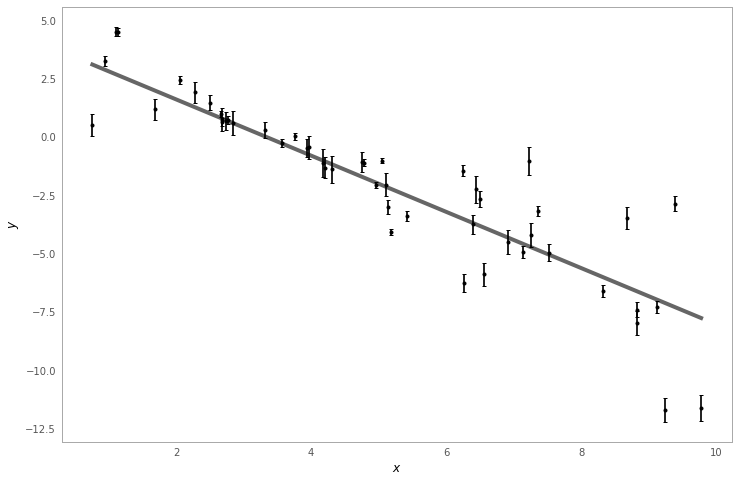

In [71]:
# See how the data and errors look
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$', fontsize=12)
ax.plot(x,m_true*x+b_true,color='k',alpha=0.6,lw=4)
ax.errorbar(x,y,yerr=yerr,fmt='ko',markersize=3,capsize=2,capthick=1)
ax.grid()
plt.show()

In [38]:
# Numerically optimize likelihood
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m*x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

# I should look into what lambda does because I have no idea what's happening here
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
# What do we do if we don't know the true parameter values?

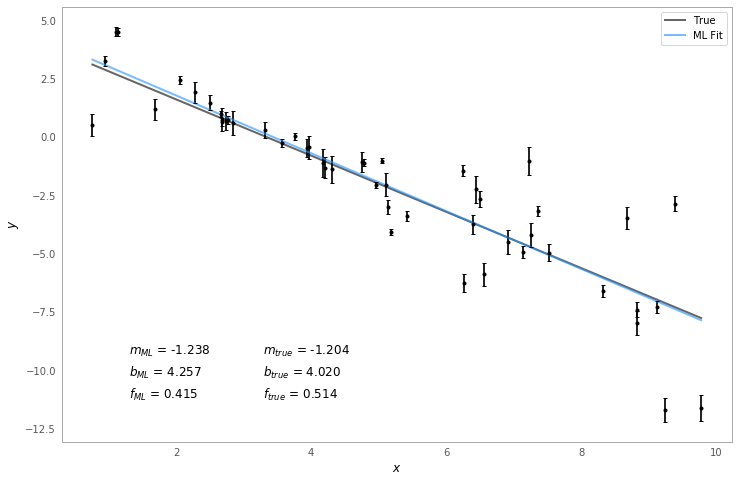

In [72]:
# Let's see how this fit looks
# See how the data and errors look
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(r'$x$',fontsize=12)
ax.set_ylabel(r'$y$', fontsize=12)
ax.plot(x,m_true*x+b_true,color='k',alpha=0.6,lw=2, label='True')
ax.plot(x,m_ml*x+b_ml,color='dodgerblue',alpha=0.6,lw=2, label='ML Fit')
ax.errorbar(x,y,yerr=yerr,fmt='ko',markersize=3,capsize=2,capthick=1)
ax.text(0.1,0.2,r'$m_{ML}$ = %4.3f' %m_ml, fontsize=12, transform=ax.transAxes)
ax.text(0.1,0.15,r'$b_{ML}$ = %4.3f' %b_ml, fontsize=12, transform=ax.transAxes)
ax.text(0.1,0.1,r'$f_{ML}$ = %4.3f' %np.exp(lnf_ml), fontsize=12, transform=ax.transAxes)
ax.text(0.3,0.2,r'$m_{true}$ = %4.3f' %m_true, fontsize=12, transform=ax.transAxes)
ax.text(0.3,0.15,r'$b_{true}$ = %4.3f' %b_true, fontsize=12, transform=ax.transAxes)
ax.text(0.3,0.1,r'$f_{true}$ = %4.3f' %f_true, fontsize=12, transform=ax.transAxes)
ax.grid()
ax.legend()
plt.show()

In [51]:
# Now for the MCMC stuff
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# Nice list comprehension--I always forget how to do this/when it would be useful

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, 500)
samples = sampler.chain[:, 50:, :].reshape((-1,ndim))

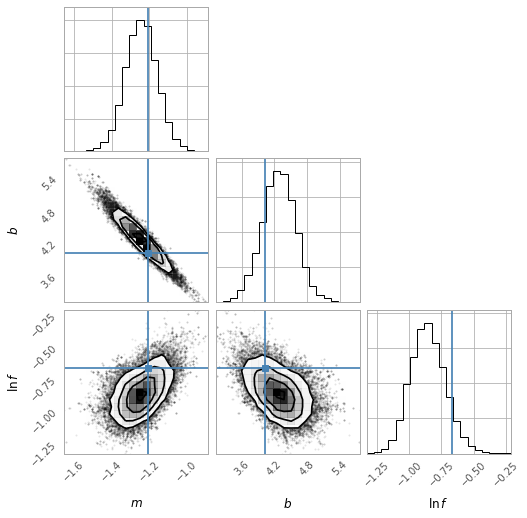

In [73]:
# Let's look at the corner plot
fig = corner.corner(samples, labels=[r'$m$', r'$b$', r'$\ln\,f$'],
                             truths=[m_true, b_true, np.log(f_true)])
plt.show()

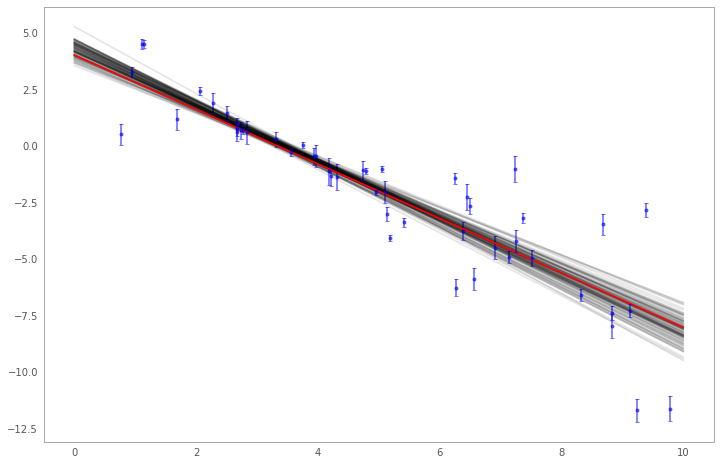

In [98]:
# Let's look at how all the fits are distributed

xl = np.array([0,10])
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(xl, m*xl+b, color='k', alpha=0.1)
ax.plot(xl, m_true*xl+b_true, color='red', alpha=1)
ax.errorbar(x, y, yerr=yerr, fmt='bo', alpha=0.55, capsize=2, capthick=1, markersize=3)
ax.grid()
plt.show()

In [108]:
# And see what the reported values are...
samples[:,2] = np.exp(samples[:,2]) # Should really put this line in a separate cell...
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16,50,84], axis=0)))

In [112]:
# I'm having some trouble formatting the values with uncertainties on the plot
# so I'm just going to print them out here
# The first entry is the best-fit value
# The second entry is the upper uncertainty
# The third entry is the lower uncertainty
print m_mcmc, '\n', b_mcmc, '\n', f_mcmc

(-1.2423089346417906, 0.08394639776928248, 0.08410531013174616) 
(4.281642387075605, 0.30567418678114944, 0.31370289684123964) 
(0.4232680692325735, 0.0638022643530986, 0.0522939098764022)


In [111]:
# The true values for reference
print m_true, '\n', b_true, '\n', f_true

-1.20374 
4.01991 
0.5143
